In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from pathlib import Path
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
from time import perf_counter_ns as pc
import time

# New Mediapipe Solution

## Demo

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [7]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, result):
    hand_landmarks_list = result.hand_landmarks
    handedness_list = result.handedness
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for hand_landmarks, handedness in zip(result.hand_landmarks, result.handedness):

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          solutions.drawing_styles.get_default_hand_landmarks_style(),
          solutions.drawing_styles.get_default_hand_connections_style())

        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN

        # Draw handedness (left or right hand) on the image.
        cv2.putText(annotated_image, f"{handedness[0].category_name}",
                    (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                    FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

    return annotated_image, hand_landmarks, handedness

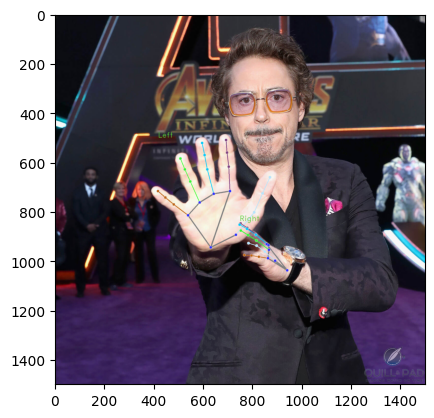

In [44]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

image = mp.Image.create_from_file("downey.jpg")

detection_result = detector.detect(image)

annotated_image, hand_landmarks, handedness = draw_landmarks_on_image(image.numpy_view(), detection_result)
plt.imshow(annotated_image)
plt.show()

In [59]:
def extract_hand(result):
    rh = lh = np.zeros((21, 3))
    
    for hand_landmarks, handedness in zip(result.hand_landmarks, result.handedness):
        assert len(handedness) == 1, "Unexpected Error in handedness"
        
        if handedness[0].category_name == 'Left':
            lh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
        if handedness[0].category_name == 'Right':
            rh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
    
    hand_pose = np.concatenate((rh, lh), axis=0)
    return hand_pose

In [60]:
hand_pose = extract_hand(detection_result)
hand_pose.shape

(42, 3)

## Extract from video

### Define utility functions

In [2]:
def extract_hand(result):
    rh = lh = np.zeros((21, 3))
    
    for hand_landmarks, handedness in zip(result.hand_landmarks, result.handedness):
        assert len(handedness) == 1, "Unexpected Error in handedness"
        
        if handedness[0].category_name == 'Left':
            lh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
        if handedness[0].category_name == 'Right':
            rh = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
    hand_pose = np.concatenate((rh, lh), axis=0)
    return hand_pose


def extract_hand_unordered(result):
    if len(result.handedness) == 0:
        return np.zeros((42, 3))
    
    elif len(result.handedness) == 1:
        hands = np.zeros((42, 3))
        for hand_landmarks in result.hand_landmarks:
            hand = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
            hands[:21] = hand
    elif len(result.handedness) == 2:
        hands = []
        for hand_landmarks in result.hand_landmarks:
            hand = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks])
            hands.append(hand)
        hands = np.concatenate(hands, axis=0)
    return hands

def extract_arm(result):
    extracted_keypoints = [
        solutions.pose.PoseLandmark.LEFT_SHOULDER.value,
        solutions.pose.PoseLandmark.RIGHT_SHOULDER.value,
        solutions.pose.PoseLandmark.LEFT_ELBOW.value,
        solutions.pose.PoseLandmark.RIGHT_ELBOW.value,
        solutions.pose.PoseLandmark.LEFT_WRIST.value,
        solutions.pose.PoseLandmark.RIGHT_WRIST.value
    ]
    n_keypoints = len(extracted_keypoints)
    arm_pose = np.zeros((n_keypoints, 3))
    
    for landmarks in result.pose_landmarks:
        extracted_lms = [landmarks[i] for i in extracted_keypoints]
        for i in range(n_keypoints):
            lm = extracted_lms[i]
            arm_pose[i] = (lm.x, lm.y, lm.z)
            
    return arm_pose    


def draw_hand(rgb_image, detection_result):
    MARGIN = 10  # pixels
    FONT_SIZE = 1
    FONT_THICKNESS = 1
    HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green

    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style())

        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks]
        y_coordinates = [landmark.y for landmark in hand_landmarks]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN

        # Draw handedness (left or right hand) on the image.
        cv2.putText(annotated_image, f"{handedness[0].category_name}",
                    (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                    FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

    return annotated_image

def draw_arm(annotated_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

### Get list of videos for pose extraction

In [3]:
video_root = '../data/video'

video_list = []
for folder in Path(video_root).iterdir():
    for mp4 in Path(folder).glob('*.mp4'):
        video_list.append(mp4.as_posix())
        
def sort_key(name):
    name = name.split('/')[3]
    idx = int(name.split('_')[0][1:])
    return idx

video_list.sort(key=sort_key)

### Main code

In [7]:
# Define variables
BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode

HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions

PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions


# Create a hand landmarker instance with the video mode:
hand_options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=2)

arm_options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path="pose_landmarker_lite.task"),
    running_mode=VisionRunningMode.VIDEO)


with HandLandmarker.create_from_options(hand_options) as hand_landmarker, \
        PoseLandmarker.create_from_options(arm_options) as arm_landmarker:
    
    save_root = './pose_new_v2'
    counter = 0
    
    for video in video_list:
        save_to = video.split('/')[-1].split('.')[0]
        if save_to != "s10_PhamQuangDai_1":
            continue
        print(save_to)
        save_to = os.path.join(save_root, save_to)
        
        since = time.time()
        cap = cv2.VideoCapture(video)
        result = []
    
        while True:
            ret, frame = cap.read()

            if not ret:
                break

            counter += 1
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            annotated_frame = mp_image.numpy_view()

            # Process hand
            hand_result = hand_landmarker.detect_for_video(mp_image, counter)
            hand_pose = extract_hand(hand_result)

            # Process arm
#             arm_result = arm_landmarker.detect_for_video(mp_image, counter)
#             arm_pose = extract_arm(arm_result)

#             final_pose = np.concatenate((hand_pose, arm_pose), axis=0)
#             assert final_pose.shape == (48, 3), f"Self defined --> {final_pose.shape}"
#             result.append(final_pose)

    #         Debugging
            if hand_pose.sum() != 0:
                has_hand = "True"
            else:
                has_hand = "False"
            annotated_frame = draw_hand(annotated_frame, hand_result)
#             annotated_frame = draw_arm(annotated_frame, arm_result)

            
            annotated_frame = cv2.putText(annotated_frame, str(counter), (200, 200), cv2.FONT_HERSHEY_SIMPLEX, 
                       1, (255, 0, 0), 2, cv2.LINE_AA)
            annotated_frame = cv2.putText(annotated_frame, has_hand, (300, 200), cv2.FONT_HERSHEY_SIMPLEX, 
                       1, (255, 0, 0), 2, cv2.LINE_AA)
            annotated_frame = cv2.resize(annotated_frame, (1080, 720))
            cv2.imshow("", cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
#         print(round(time.time() - since))
#         result = np.array(result)
#         np.save(save_to, result)

cap.release()
cv2.destroyAllWindows()

s10_PhamQuangDai_1


# Mediapipe Legacy

In [6]:
import cv2
import mediapipe as mp

# Grabbing the Holistic Model from Mediapipe and
# Initializing the Model
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

In [7]:
def extract_hand(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))
    return np.concatenate([lh, rh], axis=0)

def extract_arm(results):
    if not results.pose_landmarks:
        return np.zeros((6, 3))
    
    pose = []
    for landmark in results.pose_landmarks.landmark[11:17]:
        pose.append([[landmark.x, landmark.y, landmark.z]])
    pose = np.concatenate(pose, axis=0)
    assert pose.shape == (6, 3), f"Wrong pose shape: {pose.shape}"
    return pose

In [9]:
video_root = '../data/video'

video_list = []
for folder in Path(video_root).iterdir():
    for mp4 in Path(folder).glob('*.mp4'):
        video_list.append(mp4.as_posix())
        
def sort_key(name):
    name = name.split('/')[3]
    idx = int(name.split('_')[0][1:])
    return idx

video_list.sort(key=sort_key)

In [13]:
import cv2
import mediapipe as mp

mp_holistic = mp.solutions.holistic
save_root = './pose_legacy' 

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for video in video_list:
        save_to = Path(video).stem
        print(save_to)
        save_to = os.path.join(save_root, save_to)
        cap = cv2.VideoCapture(video)
        result = []
        
        while True:
            success, image = cap.read()

            if not success:
                break

            image.flags.writeable = False
            rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(rgb_image)
            image.flags.writeable = True

            # Extract pose
            hand_pose = extract_hand(results)
            arm_pose = extract_arm(results)
            final_pose = np.concatenate([hand_pose, arm_pose], axis=0)
            assert final_pose.shape == (48, 3), f"Wrong final pose: {final_pose.shape}"
            result.append(final_pose)
            
        result = np.array(result)
        np.save(save_to, result)

        cap.release()
        cv2.destroyAllWindows()

s1_Jeremy_1
s1_Jeremy_2
s1_Jeremy_3
s2_Alex_1
s2_Alex_2
s2_Alex_3
s3_Theo_1
s3_Theo_2
s3_Theo_3
s4_Gabin_1
s4_Gabin_2
s4_Gabin_3
s5_Adrien_1
s5_Adrien_2
s5_Adrien_3
s6_LeVietDuc_1
s6_LeVietDuc_2
s6_LeVietDuc_3
s7_TranVanThang_1
s7_TranVanThang_2
s7_TranVanThang_3
s8_PhamMinhHung_1
s8_PhamMinhHung_2
s8_PhamMinhHung_3
s9_NgoDuyKhanh_1
s9_NgoDuyKhanh_2
s9_NgoDuyKhanh_3
s10_PhamQuangDai_1
s10_PhamQuangDai_2
s10_PhamQuangDai_3
s11_NguyenTheThao_1
s11_NguyenTheThao_2
s11_NguyenTheThao_3
s12_NguyenXuanHieu_1
s12_NguyenXuanHieu_2
s12_NguyenXuanHieu_3
s13_TranNhatNam_1
s13_TranNhatNam_2
s13_TranNhatNam_3
s14_Alexandre_1
s14_Alexandre_2
s14_Alexandre_3
s15_Liheng_1
s15_Liheng_2
s15_Liheng_3
s17_Ahmed_1
s17_Ahmed_2
s17_Ahmed_3
s18_SungBin_1
s18_SungBin_2
s18_SungBin_3
s19_Enzo_1
s19_Enzo_2
s19_Enzo_3
s20_TranHuyKhanh_1
s20_TranHuyKhanh_2
s20_TranHuyKhanh_3
s21_HoangSon_1
s21_HoangSon_2
s21_HoangSon_3
s22_MaiQuangTung_1
s22_MaiQuangTung_2
s22_MaiQuangTung_3
s23_DangHoangLong_1
s23_DangHoangLong_2


In [3]:
import os
import cv2
import mediapipe as mp
import numpy as np


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=2,
                       min_detection_confidence=0.5,
                       min_tracking_confidence=0.5)

base_dir = "../data/video"

pose_dir = "../data/pose_legacy_order"
os.makedirs(pose_dir, exist_ok=True)

for subject in os.listdir(base_dir):
    subject_dir = os.path.join(base_dir, subject)
    if not os.path.isdir(subject_dir):
        continue

    for video_file in os.listdir(subject_dir):
        if not video_file.endswith(".mp4"):
            continue
        
        pose_file = os.path.join(pose_dir, f'{video_file.split(".")[0]}.npy')
        if os.path.exists(pose_file):
            print(f'Skip {video_file}')
            continue

        video_path = os.path.join(subject_dir, video_file)
        cap = cv2.VideoCapture(video_path)

        frame_index = 0
        pose_data = {}

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.flip(frame, 1)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = hands.process(frame_rgb)
            
            if results.multi_hand_landmarks:
                hand_poses = np.zeros((42, 3))
                for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                    hand_pose = []
                    # Iterate through each hand landmark
                    for landmark in hand_landmarks.landmark:
                        # Extract 3D landmark coordinates
                        x = landmark.x
                        y = landmark.y
                        z = landmark.z
                        hand_pose.append((x, y, z))
                    if handedness.classification[0].label == 'Left':
                        hand_poses[:21] = np.array(hand_pose)
                    elif handedness.classification[0].label == 'Right':
                        hand_poses[21:] = np.array(hand_pose)
                    else:
                        print(handedness)
                        raise

                pose_data[frame_index] = hand_poses

            frame_index += 1

        # Release the video capture
        cap.release()

        # Save pose data to file
        video_name = os.path.splitext(video_file)[0]
        pose_file = os.path.join(pose_dir, f"{video_name}.npy")
        np.save(pose_file, pose_data)

        print(f"Saved pose data for video: {video_name}")


Saved pose data for video: s10_PhamQuangDai_1
Saved pose data for video: s10_PhamQuangDai_2
Saved pose data for video: s10_PhamQuangDai_3
Saved pose data for video: s11_NguyenTheThao_1
Saved pose data for video: s11_NguyenTheThao_2
Saved pose data for video: s11_NguyenTheThao_3
Saved pose data for video: s12_NguyenXuanHieu_1
Saved pose data for video: s12_NguyenXuanHieu_2
Saved pose data for video: s12_NguyenXuanHieu_3
Saved pose data for video: s13_TranNhatNam_1
Saved pose data for video: s13_TranNhatNam_2
Saved pose data for video: s13_TranNhatNam_3
Saved pose data for video: s14_Alexandre_1
Saved pose data for video: s14_Alexandre_2
Saved pose data for video: s14_Alexandre_3
Saved pose data for video: s15_Liheng_1
Saved pose data for video: s15_Liheng_2
Saved pose data for video: s15_Liheng_3
Saved pose data for video: s17_Ahmed_1
Saved pose data for video: s17_Ahmed_2
Saved pose data for video: s17_Ahmed_3
Saved pose data for video: s18_SungBin_1
Saved pose data for video: s18_Sung